In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf

## Fetching the Data 

This is a bit annoying. But to download from kaggle we need to upload the kaggle API key here. Then we need to move the file to the correct folder after which we need to change the permissions. The error messages will not provide super helpful information so I've added the correct code here. 

You can also upload the dataset from kaggle manually or you can download all of this locally. The kaggle dataset can be found [here](https://www.kaggle.com/therohk/million-headlines).

Then again, this code works;

In [0]:
# from google.colab import files
# files.upload()

{}

In [0]:
# ! cp kaggle.json ~/.kaggle/}
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d therohk/million-headlines

million-headlines.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
headlines = pd.read_csv('million-headlines.zip')['headline_text']

## Sequence of Letters 

Let's now take these headlines and grab sequences of letters out of them.

In [0]:
headlines[0]

'aba decides against community broadcasting licence'

In [0]:
import itertools as it 

def sliding_window(txt):
  for i in range(len(txt) - 1):
    yield txt[i], txt[i + 1]

window = list(it.chain(*[sliding_window(_) for _ in headlines[:10000]]))

In [0]:
mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}
integers_in = np.array([mapping[w[0]] for w in window])
integers_out = np.array([mapping[w[1]] for w in window]).reshape(-1, 1)

In [0]:
integers_in.shape

(38976,)

In [0]:
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential

num_letters = len(mapping) # typically 36 -> 26 letters + 10 numbers

# this one is so we might grab the embeddings
model_emb = Sequential()
embedding = Embedding(num_letters, 2, input_length=1)
model_emb.add(embedding)
output_array = model_emb.predict(integers_in)
output_array.shape

(386880, 1, 2)

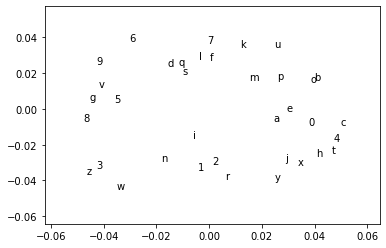

In [0]:
import matplotlib.pylab as plt

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v:k for k,v in mapping.items()}
preds = model_emb.predict(idx_to_calc)

plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
  plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

In [0]:
from tensorflow.keras.optimizers import Adam

# this one is so we might learn the mapping
model_pred = Sequential()
model_pred.add(embedding)
model_pred.add(Flatten())
model_pred.add(Dense(num_letters, activation="softmax"))

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_pred.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

output_array = model_pred.predict(integers_in)
output_array.shape

(386880, 37)

In [0]:
from sklearn.preprocessing import OneHotEncoder

to_predict = OneHotEncoder(sparse=False).fit_transform(integers_out)
model_pred.fit(integers_in, to_predict, epochs=30, verbose=1)

Train on 386880 samples
Epoch 1/30
386880/386880 [==============================] - 20s 52us/sample - loss: 2.7431 - accuracy: 0.1801
Epoch 2/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6724 - accuracy: 0.1922
Epoch 3/30
386880/386880 [==============================] - 20s 52us/sample - loss: 2.6689 - accuracy: 0.1960
Epoch 4/30
386880/386880 [==============================] - 20s 52us/sample - loss: 2.6675 - accuracy: 0.1960
Epoch 5/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6666 - accuracy: 0.1960
Epoch 6/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6660 - accuracy: 0.1963
Epoch 7/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6655 - accuracy: 0.1964
Epoch 8/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6650 - accuracy: 0.1963
Epoch 9/30
386880/386880 [==============================] - 20s 51us/sample - loss: 2.6646 - acc

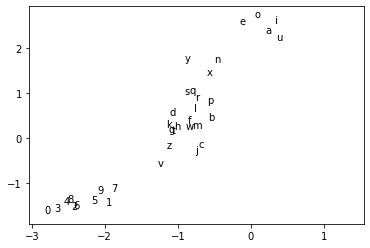

In [0]:
preds = model_emb.predict(idx_to_calc)
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
  plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])